# Center Loss in Keras - Fine Tuning

## Item recognition 'the sequel' - using Center Loss with Transfer Learning


Pretrained model: InceptionV3

The implementation of **Center Loss** came from: [handongfeng/MNIST-center-loss](https://github.com/handongfeng/MNIST-center-loss/blob/master/centerLoss_MNIST.py)

**Articles:**
- [A Discriminative Feature Learning Approach for Deep Face Recognition](https://ydwen.github.io/papers/WenECCV16.pdf)
- [Understanding Center Loss Based Network for Image Retrieval with Few Training Data](https://openaccess.thecvf.com/content_ECCVW_2018/papers/11132/Ghosh_Understanding_Center_Loss_Based_Network_for_Image_Retrieval_with_Few_ECCVW_2018_paper.pdf)

### NOTE

lambda centerloss = 0.01 in *funetuning2* might be still to large. So in this notebook I will try smaller value. 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
%matplotlib notebook
%load_ext tensorboard

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#from tensorflow.keras.preprocessing import image_dataset_from_directory # cant import in Tensorflow v2.2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.regularizers import l2
from tensorflow.keras import losses
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import default_rng
import pickle

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


In [3]:
#import os

In [4]:
from centerLoss import prelu, zero_loss, my_model
from centerLoss import CenterLossLayer

In [5]:
from utils import tbProjector, PCAPlotter, create_testdata

In [6]:
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[]

In [7]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Counting Training Data 

In [8]:
image_dir = "image_data"
train_dir = os.path.join(image_dir, "train")
print(train_dir)

train_classnum = len(os.listdir(train_dir))
print("items = {}".format(len(os.listdir(train_dir))))

image_data/train
items = 706


In [9]:
all_images = 0
class_list = sorted(os.listdir(train_dir))
for i in class_list:
    #print(i)
    all_images += len(os.listdir(os.path.join(train_dir, i)))
print("All image files = {}".format(all_images))
print("class_list[:10] = {}".format(class_list[:10]))

All image files = 12070
class_list[:10] = ['aubeer2_0', 'aubeer2_1', 'aubeer2_10', 'aubeer2_11', 'aubeer2_12', 'aubeer2_14', 'aubeer2_15', 'aubeer2_16', 'aubeer2_17', 'aubeer2_18']


In [10]:
#_BATCH_SIZE = 1024
#_BATCH_SIZE = 256
_BATCH_SIZE = 64

## Setup train data generator

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'image_data/train',
    target_size=(224, 224),
    batch_size=_BATCH_SIZE,
    class_mode='categorical'
    ) 

Found 12070 images belonging to 706 classes.


In [12]:
def plot_dataset(image_samples):

    #plt.figure(figsize=(5, 2))
    fig, axs = plt.subplots(len(image_samples)//5, 5)
                            
    count = 0
    for i in range(len(image_samples)//5):
        for j in range(5):
            #print("i = {}, j = {}".format(i, j))
            #plt.subplot(3, 3, 1 + i + j)
            axs[i, j].imshow(image_samples[count])
            plt.xticks([])
            plt.yticks([])
            count+=1
        #plt.title(examples[1][i])
    plt.show()

(64, 224, 224, 3)
(64, 706)


<IPython.core.display.Javascript object>


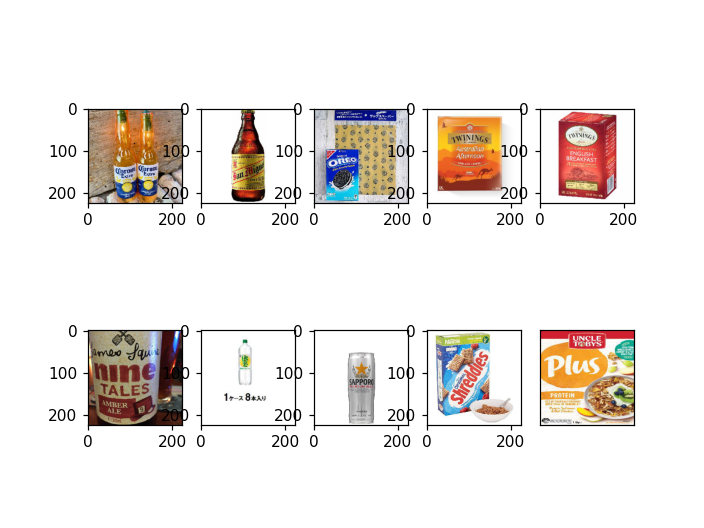

In [13]:
#X, Y = train_ds
(X, Y) = next(train_generator)
print(X.shape)
print(Y.shape)

plot_dataset(X[:10])
#print(Y[:10])

In [14]:
labelnames = list(train_generator.class_indices.keys())

for y_onehot in Y[:10]:
    idx = np.argmax(y_onehot, axis=0)
    print(labelnames[idx]) 

aubeer2_32
aubeer2_82
snack46
austeafood_000020
austeafood_000025
aubeer_52
drink29
aubeer2_54
cereal_66
cereal_39


## Load a pre-trained model and attach some fully-connected layers

In [15]:
emb_size = 128

img_input = keras.Input(shape=(224, 224, 3))
train_labels = keras.Input(shape=(train_classnum,))

final_output, side_output, base_model = my_model(img_input, train_labels, emb_size)
model = keras.Model(inputs=[img_input, train_labels], outputs=[final_output, side_output])
model.summary()

706
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 5, 5, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           inception_v3[1][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           global_average_pooling2d[0][0]   
__________________________________________________________________________________________

## compile

In [16]:
lambda_centerloss = 0.001
initial_learning_rate = 0.001

optim = optimizers.SGD(lr=initial_learning_rate, momentum=0.9)
model.compile(optimizer=optim,
                  loss=[losses.categorical_crossentropy, zero_loss],
                  #loss_weights=[1, lambda_centerloss])
                  loss_weights=[1, lambda_centerloss])

## Define data generation wrapper

In [17]:
def datagen_wrapper(gen, batch_size=64):
    dummy = np.zeros((batch_size, 1))
    #dummy2 = np.zeros((x_test.shape[0], 1))
    while True:
        (X, Y) = next(gen)    
        yield([X, Y], [Y, dummy])


## Prepare Tensorboard log

In [18]:
from datetime import date, time, datetime
import time

#datetimestr = datetime.now().__str__()
#timestamp = datetimestr.split()[0] + "_" + datetimestr.split()[1].split('.')[0]

epoch_time = int(time.time())

In [19]:
log_dir_rel = "logs/logs-{}".format(epoch_time)
#log_dir = os.path.abspath(log_dir_rel)
log_dir = os.path.abspath("logs/train_log")

if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    
_TB_METADATA = 'metadata.tsv'

print(log_dir)

/home/chieko/Projects/ImageRecognition2/ItemRecogCenterLoss/logs/train_log


In [20]:
# Validation Data for Tensorboard
x_tb, x_tb_label_list = create_testdata(datadir='train', tblog_dir=log_dir, metadatafile=_TB_METADATA)
y_tb = np.zeros((x_tb.shape[0], emb_size))

x_tb_label = [ train_generator.class_indices[label] for label in x_tb_label_list ]
print(x_tb_label)

[310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 702, 702, 702, 702, 702, 702, 702, 702, 702, 702, 702, 702, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 520, 520, 520, 520, 520, 520, 520, 520, 520, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 626, 626, 626, 626, 626, 626, 626, 626, 626, 626, 626, 626, 626, 626, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587]


## Training with pre-trained model being untrainable

<IPython.core.display.Javascript object>


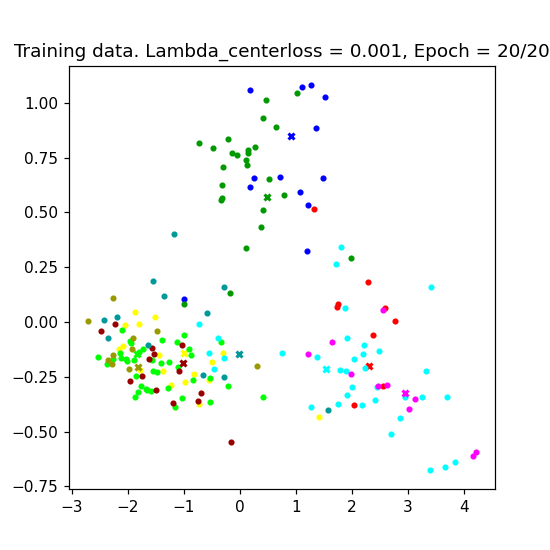

Epoch 1/20
188/188 [==============================] - 281s 1s/step - loss: 6.8609 - main_out_loss: 6.5685 - centerlosslayer_loss: 250.4683
Epoch 2/20
188/188 [==============================] - 290s 2s/step - loss: 6.6669 - main_out_loss: 6.5575 - centerlosslayer_loss: 67.6418
Epoch 3/20
188/188 [==============================] - 290s 2s/step - loss: 6.6348 - main_out_loss: 6.5486 - centerlosslayer_loss: 44.4685
Epoch 4/20
188/188 [==============================] - 289s 2s/step - loss: 6.6182 - main_out_loss: 6.5420 - centerlosslayer_loss: 34.5687
Epoch 5/20
188/188 [==============================] - 290s 2s/step - loss: 6.6048 - main_out_loss: 6.5338 - centerlosslayer_loss: 29.3781
Epoch 6/20
188/188 [==============================] - 290s 2s/step - loss: 6.5932 - main_out_loss: 6.5257 - centerlosslayer_loss: 25.8618
Epoch 7/20
188/188 [==============================] - 289s 2s/step - loss: 6.5817 - main_out_loss: 6.5162 - centerlosslayer_loss: 23.9397
Epoch 8/20
188/188 [=============

In [21]:
epochs=20
steps_per_epoch = int(all_images/_BATCH_SIZE)
#steps_per_epoch = 10

save_path = "result_noft_{}".format(epoch_time)
reduced_model = keras.Model(inputs=model.input[0], outputs=model.get_layer('side_out').output)

his = model.fit(datagen_wrapper(train_generator, _BATCH_SIZE),
            steps_per_epoch=steps_per_epoch,
            #batch_size=_BATCH_SIZE,
            epochs=epochs,
            verbose=1,
            callbacks=[
                    tbProjector(reduced_model, x_tb, y_tb, log_dir, _TB_METADATA),
                    PCAPlotter(plt, model, reduced_model, x_tb, x_tb_label, epochs, lambda_centerloss, save_path)])

**NOTE**

- `lambda = 0.01`: Most of the points which represent samples became tightly close to each other, looking like it's just one point in the plot at the end of the first epoch.

- `lambda = 0.0007 - 0.001 - 0.003`: Better. But after around 10th epoch, center loss started to increase AND keep increasing although it was reasonably decreasing until that point. On the other hand, main loss (categorical cross entropy) kept decreasing throughout the training.

In [22]:
reduced_filename = "reduced_noft_" + str(epoch_time) + ".h5"
reduced_model.save(reduced_filename)
print("Trained model was saved into {}.".format(reduced_filename))

Trained model was saved into reduced_noft_1610367498.h5.


In [23]:
with open('{}/History.pkl'.format(save_path), 'wb') as file_pi:
    pickle.dump(his.history, file_pi)

## Fine Tuning

In [24]:
base_model.trainable = True

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 5, 5, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           inception_v3[1][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           global_average_pooling2d[0][0]   
______________________________________________________________________________________________

In [26]:
#lambda_centerloss = 0.01
lambda_centerloss = 0.001

optim = optimizers.SGD(lr=0.0001, momentum=0.9)
model.compile(optimizer=optim,
                  loss=[losses.categorical_crossentropy, zero_loss],
                  loss_weights=[1, lambda_centerloss])

<IPython.core.display.Javascript object>


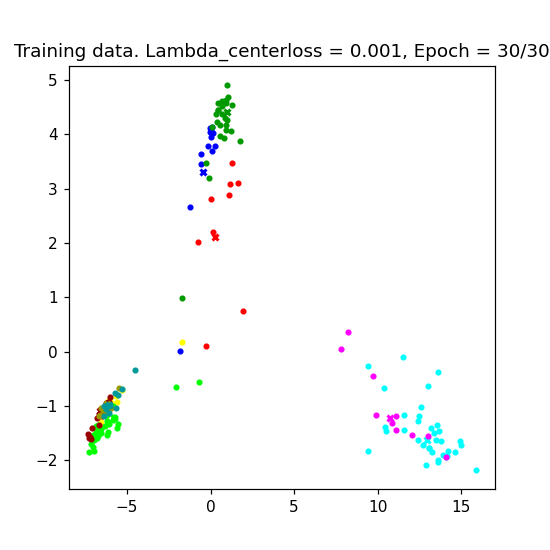

Epoch 1/30
188/188 [==============================] - 1318s 7s/step - loss: 6.3944 - main_out_loss: 6.3059 - centerlosslayer_loss: 47.0379
Epoch 2/30
188/188 [==============================] - 1318s 7s/step - loss: 6.3746 - main_out_loss: 6.2819 - centerlosslayer_loss: 51.2536
Epoch 3/30
188/188 [==============================] - 1316s 7s/step - loss: 6.3464 - main_out_loss: 6.2496 - centerlosslayer_loss: 55.3657
Epoch 4/30
188/188 [==============================] - 1319s 7s/step - loss: 6.3359 - main_out_loss: 6.2362 - centerlosslayer_loss: 58.2356
Epoch 5/30
188/188 [==============================] - 1319s 7s/step - loss: 6.3219 - main_out_loss: 6.2213 - centerlosslayer_loss: 59.1409
Epoch 6/30
188/188 [==============================] - 1317s 7s/step - loss: 6.3060 - main_out_loss: 6.2027 - centerlosslayer_loss: 61.8009
Epoch 7/30
188/188 [==============================] - 1319s 7s/step - loss: 6.3022 - main_out_loss: 6.1975 - centerlosslayer_loss: 63.2133
Epoch 8/30
188/188 [=======

In [27]:
epochs=30
steps_per_epoch = int(all_images/_BATCH_SIZE)
#steps_per_epoch = 10

save_path_ft = "result_ft_{}".format(epoch_time)
reduced_model = keras.Model(inputs=model.input[0], outputs=model.get_layer('side_out').output)

his = model.fit(datagen_wrapper(train_generator, _BATCH_SIZE),
            steps_per_epoch=steps_per_epoch,
            #batch_size=_BATCH_SIZE,
            epochs=epochs,
            verbose=1,
            callbacks=[
                    tbProjector(reduced_model, x_tb, y_tb, log_dir, _TB_METADATA),
                    PCAPlotter(plt, model, reduced_model, x_tb, x_tb_label, epochs, lambda_centerloss, save_path_ft)])

**NOTE:** I cound't continue the training with GPU because of the ResourceExhaustedError. So I finally made it with CPU.

In [28]:
reduced_filename = "reduced_ft" + str(epoch_time) + ".h5"
reduced_model.save(reduced_filename)
print("Trained model was saved into {}.".format(reduced_filename))

Trained model was saved into reduced_ft1610367498.h5.


In [29]:
weights_filename = "weights_ft" + str(epoch_time) + ".h5"
model.save_weights(weights_filename)
print("Trained model weights were saved into {}.".format(weights_filename))

Trained model weights were saved into weights_ft1610367498.h5.


In [30]:
with open('{}/History.pkl'.format(save_path_ft), 'wb') as file_pi:
    pickle.dump(his.history, file_pi)